In [2]:
import os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt 

### Input for vizualisation 

In [3]:
result_folder = os.path.realpath('../test/output')

summary_stat = f'{result_folder}/summary_stat/summary_stats_combined.csv'
busco_res = f'{result_folder}/BUSCO/summary/combined_BUSCO_results.csv'
gffcompare_res = f'{result_folder}/gffcompare/summary/combined_gffcompare_extend.tsv'

In [4]:
print (summary_stat)
print (busco_res)
print (gffcompare_res)

/Users/fzanarello/Library/CloudStorage/OneDrive-CRG-CentredeRegulacioGenomica/work/projects/compann-nf/test/output/summary_stat/summary_stats_combined.csv
/Users/fzanarello/Library/CloudStorage/OneDrive-CRG-CentredeRegulacioGenomica/work/projects/compann-nf/test/output/BUSCO/summary/combined_BUSCO_results.csv
/Users/fzanarello/Library/CloudStorage/OneDrive-CRG-CentredeRegulacioGenomica/work/projects/compann-nf/test/output/gffcompare/summary/combined_gffcompare_extend.tsv


### Summary stat

This section serves to have an overview of the annotations in the analysis.  
- Effect of filtering long isoform, keeping 200bp+ RNAs and selecting only main features
- Have an overview of all the features available and their size

In [7]:
summary_df = pd.read_csv(summary_stat)
summary_df['Tool'] = summary_df['File Name'].map(lambda x : x.split('_')[3])

In [8]:
summary_df.head()

,File Name,Full/200+,Type,Number,Size total (kb),Size mean (bp),Tool
0,arabidopsis_lyrata_chr8_REF,Full,cds,16761,3784.74,225.81,REF
1,arabidopsis_lyrata_chr8_REF,Full,chromosome,1,22951.29,22951293.00,REF
2,arabidopsis_lyrata_chr8_REF,Full,exon,18433,4162.20,225.80,REF
3,arabidopsis_lyrata_chr8_REF,Full,five_prime_utr,2794,141.13,50.51,REF
4,arabidopsis_lyrata_chr8_REF,Full,gene,3476,7145.65,2055.71,REF


In [9]:
for file in sorted(summary_df['File Name'].unique()):
    ft_available = summary_df[summary_df['File Name'] == file]['Type'].unique()
    print (file, ft_available) 

arabidopsis_lyrata_chr8_REF ['cds' 'chromosome' 'exon' 'five_prime_utr' 'gene' 'mrna' 'ncrna_gene'
 'pre_mirna' 'rrna' 'snorna' 'snrna' 'three_prime_utr' 'trna' 'Total']
arabidopsis_lyrata_chr8_REF_longisoforms_200plus_basicelements ['exon' 'gene' 'mrna' 'Total']
arabidopsis_lyrata_chr8_geneid ['cds' 'exon' 'gene' 'mrna' 'Total']
arabidopsis_lyrata_chr8_geneid_longisoforms_200plus_basicelements ['exon' 'gene' 'mrna' 'Total']
arabidopsis_lyrata_chr8_geneidblastx ['cds' 'exon' 'gene' 'mrna' 'Total']
arabidopsis_lyrata_chr8_geneidblastx_longisoforms_200plus_basicelements ['exon' 'gene' 'mrna' 'Total']
arabidopsis_lyrata_chr8_helixer ['cds' 'exon' 'five_prime_utr' 'gene' 'mrna' 'three_prime_utr' 'Total']
arabidopsis_lyrata_chr8_helixer_longisoforms_200plus_basicelements ['exon' 'gene' 'mrna' 'Total']


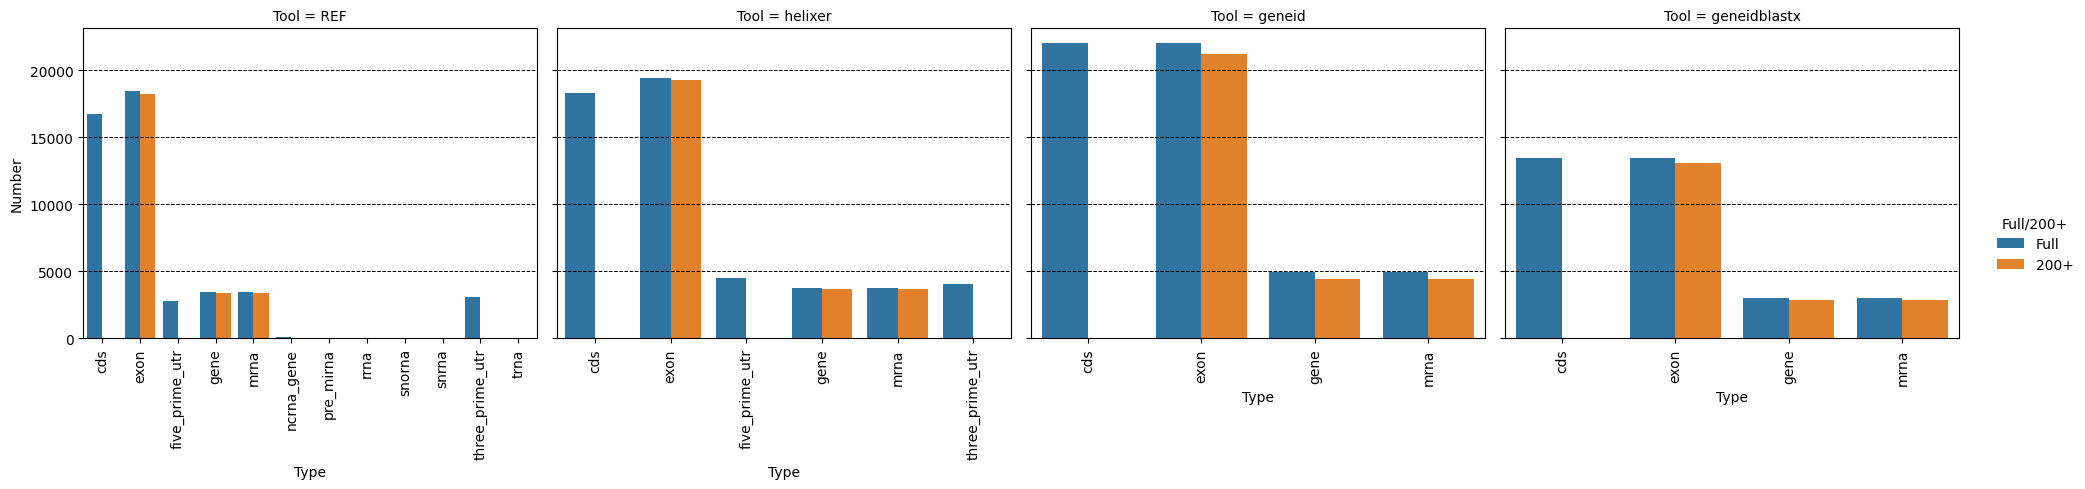

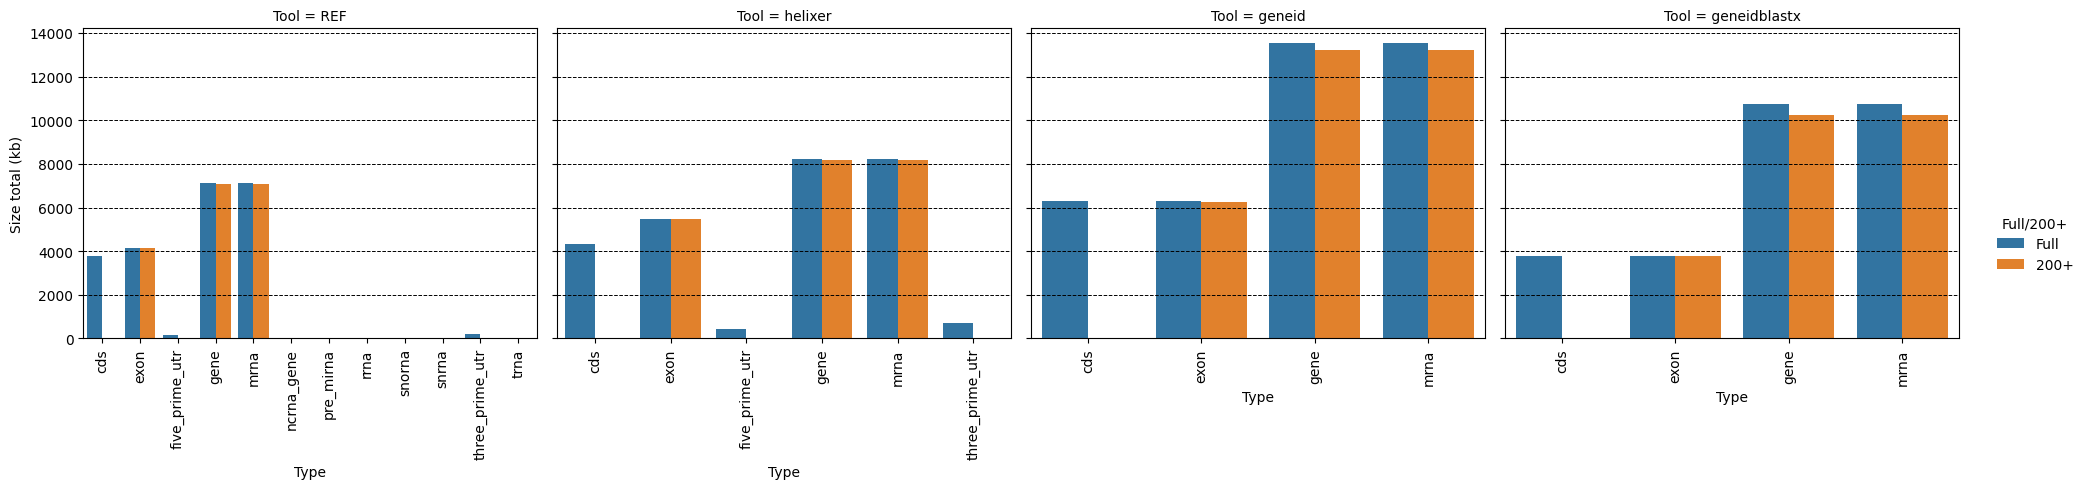

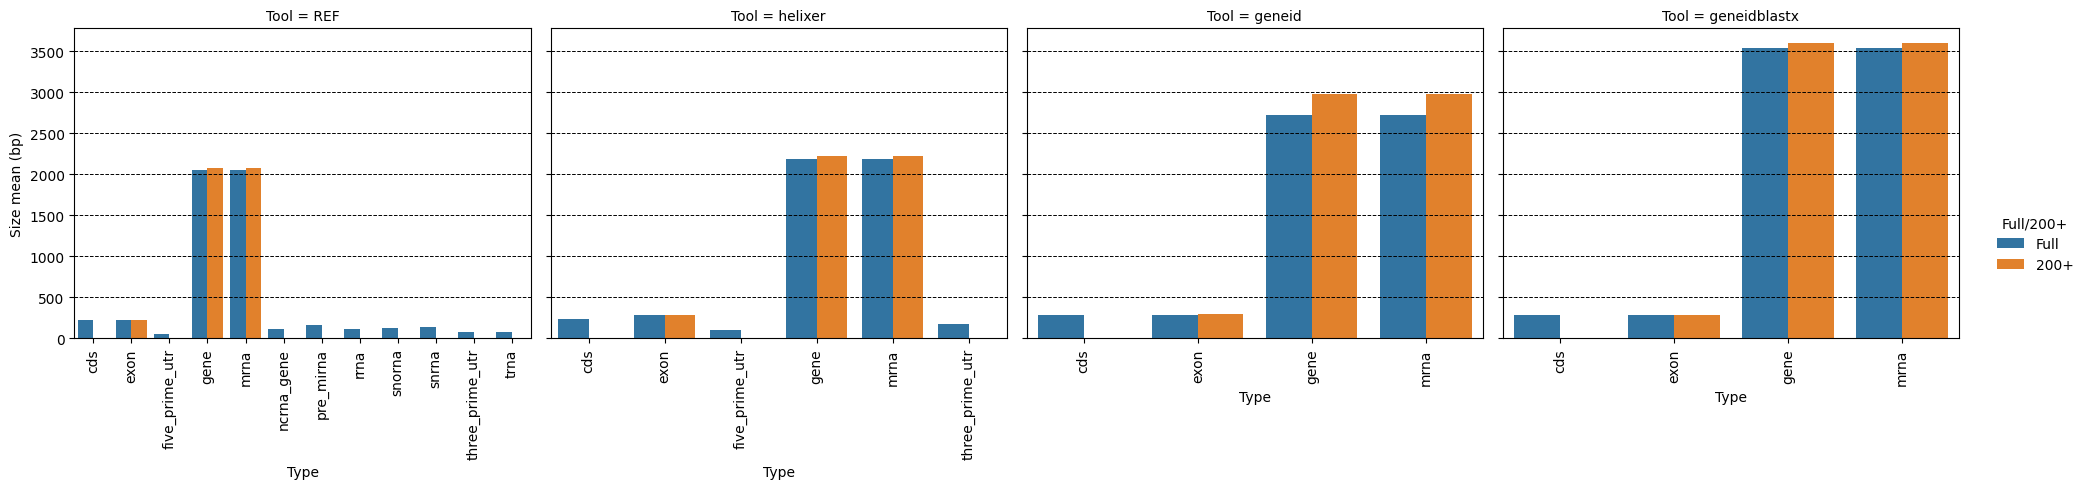

In [10]:
metrics = ['Number','Size total (kb)','Size mean (bp)']

for m in metrics:
    g = sns.catplot(
        data=summary_df[(summary_df.Type != 'Total') & (summary_df.Type != 'chromosome')], 
        x='Type', 
        y=m,
        col='Tool', 
        hue='Full/200+', 
        kind='bar',
        sharex=False, 
        sharey=True,
        facet_kws={'despine': False}
        )
    g.set_xticklabels(rotation=90)  
    g.map(plt.grid, axis='y',color='black', linestyle='--', linewidth=0.7)
    plt.show()

### BUSCO res

In [11]:
busco_df = pd.read_csv(busco_res)

In [12]:
plt_busco_df = busco_df.transpose()
plt_busco_df.index = plt_busco_df.index.map(lambda a : a.replace('BUSCO_','').replace('_CDS',''))
plt_busco_df.columns = plt_busco_df.iloc[0]
plt_busco_df = plt_busco_df.drop('metric')
plt_busco_df = plt_busco_df[['Complete percentage','Fragmented percentage','Missing percentage']].apply(pd.to_numeric)

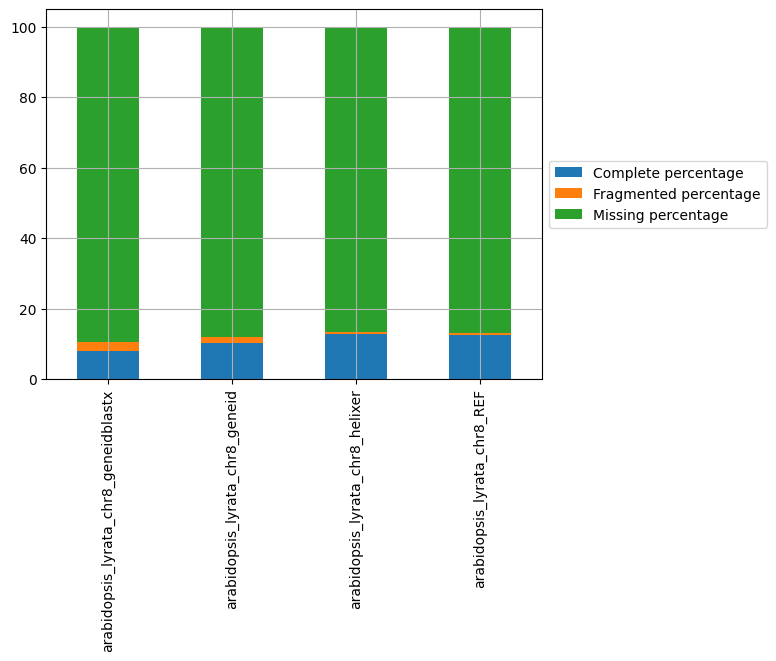

In [13]:
plt_busco_df.plot(kind='bar', stacked = 'True')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### GFF compare

In [14]:
gffcomapre_df = pd.read_csv(gffcompare_res)

In [15]:
original_column = gffcomapre_df.columns.drop('comparison')
gffcomapre_df['val'] = gffcomapre_df[original_column].bfill(axis=1).iloc[:, 0]
gffcomapre_df = gffcomapre_df.drop(original_column, axis=1)

In [16]:
gffcomapre_df['metric'] = gffcomapre_df.comparison.map(lambda x : x.split('-')[-1])
gffcomapre_df['reference'] = gffcomapre_df.comparison.map(lambda x : x.split('_vs_')[0])
gffcomapre_df['query'] = gffcomapre_df.comparison.map(lambda x : x.split('_vs_')[1].split('-')[0])
gffcomapre_df['reference_tool'] = gffcomapre_df['reference'].map(lambda x : x.split('_')[-1])
gffcomapre_df['query_tool'] = gffcomapre_df['query'].map(lambda x : x.split('_')[-1])

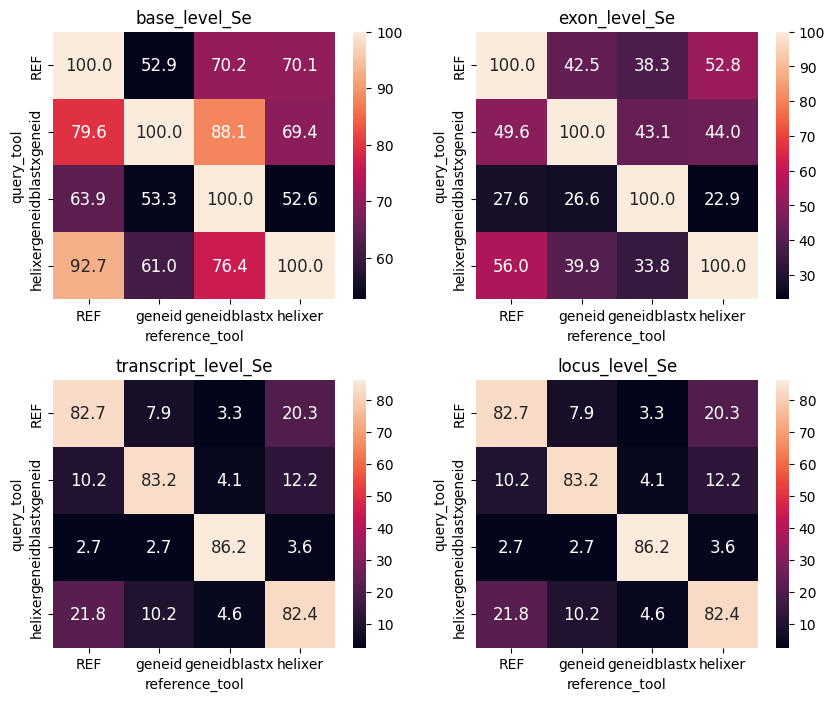

In [17]:
metrics = ['base_level_Se','exon_level_Se',  'transcript_level_Se','locus_level_Se']

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for m,ax in zip(metrics, axs.flat):

    matrix = gffcomapre_df[gffcomapre_df.metric == m].pivot(index="query_tool",
                                                            columns="reference_tool",
                                                            values="val").apply(pd.to_numeric)
    sns.heatmap(data = matrix,
                annot=True,fmt=".1f",
                annot_kws={"size": 12},
                ax=ax)
    ax.set_title(m)

plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.show()

In [18]:
gffcomapre_df

,comparison,val,metric,reference,query,reference_tool,query_tool
0,arabidopsis_lyrata_chr8_helixer_vs_arabidopsis...,2849,query_mrnas,arabidopsis_lyrata_chr8_helixer,arabidopsis_lyrata_chr8_geneidblastx,helixer,geneidblastx
1,arabidopsis_lyrata_chr8_helixer_vs_arabidopsis...,3687,reference_mrnas,arabidopsis_lyrata_chr8_helixer,arabidopsis_lyrata_chr8_geneidblastx,helixer,geneidblastx
2,arabidopsis_lyrata_chr8_helixer_vs_arabidopsis...,52.6,base_level_Se,arabidopsis_lyrata_chr8_helixer,arabidopsis_lyrata_chr8_geneidblastx,helixer,geneidblastx
3,arabidopsis_lyrata_chr8_helixer_vs_arabidopsis...,76.4,base_level_Pr,arabidopsis_lyrata_chr8_helixer,arabidopsis_lyrata_chr8_geneidblastx,helixer,geneidblastx
4,arabidopsis_lyrata_chr8_helixer_vs_arabidopsis...,22.9,exon_level_Se,arabidopsis_lyrata_chr8_helixer,arabidopsis_lyrata_chr8_geneidblastx,helixer,geneidblastx
...,...,...,...,...,...,...,...
267,arabidopsis_lyrata_chr8_geneidblastx_vs_arabid...,93,matching_loci,arabidopsis_lyrata_chr8_geneidblastx,arabidopsis_lyrata_chr8_REF,geneidblastx,REF
268,arabidopsis_lyrata_chr8_geneidblastx_vs_arabid...,3032/13095,missed_exon_prop,arabidopsis_lyrata_chr8_geneidblastx,arabidopsis_lyrata_chr8_REF,geneidblastx,REF
269,arabidopsis_lyrata_chr8_geneidblastx_vs_arabid...,23.2,missed_exon_perc,arabidopsis_lyrata_chr8_geneidblastx,arabidopsis_lyrata_chr8_REF,geneidblastx,REF
270,arabidopsis_lyrata_chr8_geneidblastx_vs_arabid...,7954/18198,novel_exon_prop,arabidopsis_lyrata_chr8_geneidblastx,arabidopsis_lyrata_chr8_REF,geneidblastx,REF


In [19]:
gffcomapre_df[gffcomapre_df.query_tool == 'REF'].metric.unique()

array(['query_mrnas', 'reference_mrnas', 'base_level_Se', 'base_level_Pr',
       'exon_level_Se', 'exon_level_Pr', 'transcript_level_Se',
       'transcript_level_Pr', 'locus_level_Se', 'locus_level_Pr',
       'matching_intron_chains', 'matching_transcripts', 'matching_loci',
       'missed_exon_prop', 'missed_exon_perc', 'novel_exon_prop',
       'novel_exon_perc'], dtype=object)

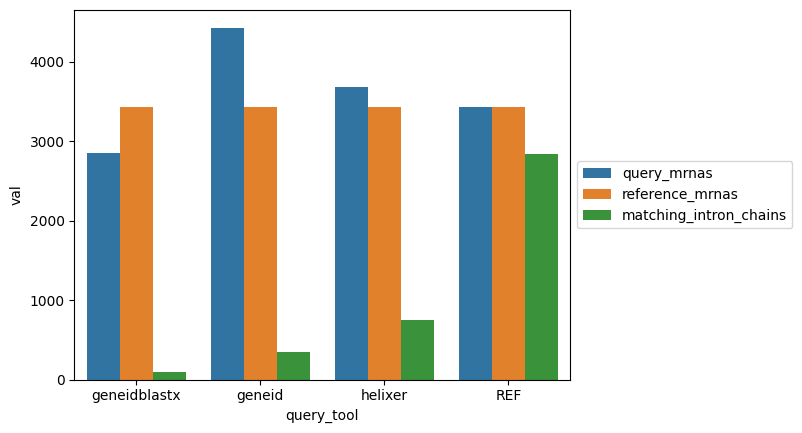

In [20]:
plotting_metric = ['query_mrnas', 'reference_mrnas','matching_intron_chains']
plotting_df = gffcomapre_df[(gffcomapre_df.reference_tool == 'REF')
                            &(gffcomapre_df.metric.isin(plotting_metric))]

sns.barplot(data = plotting_df,
            x = 'query_tool',
            y = plotting_df.val.apply(pd.to_numeric),
            hue = 'metric')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))